# Introduction to PyTorch 

## Introduction
Pytorch is a  modern, intuitive, Pythonic and fast framework for building differentiable graphs. Neural networks, as it happens, are a type of acyclic differentiable graph, making PyTorch a convenient framework to use, should you wish to build (potentially) complicated deep neural networks fairly easily.

## MLP package vs Pytorch
**Student**: Why do I have to learn to use PyTorch now? I've spent all this time working on the MLP framework. Was that a waste of time?

**TA**: Pytorch is everything the MLP package is, and more. It's faster, cleaner and far more up to date with modern deep learning advances, meaning it is easy to tailor to experiments you may wish to run. Since it is one of the main deep learning frameworks being used by industry and research alike, it conforms to the expectation of real users like researchers and engineers. The result is that PyTorch is (and continues to become) a robust and flexible package. Coming to grips with PyTorch now means that you'll be able to apply it to any future project that uses deep learning. 

Furthermore, the MLP framework was written in NumPy and your time developing this has taught you some fundamental implementation details of NNs: this could (and should) make future research directions more easy to think of and will also enable your debugging prowess. PyTorch was written to emulate NumPy as much as possible, so it will feel very familiar to you. The skills you have acquired are highly transferable (they generalize well, so not much overfitting there!).

The devleopers of PyTorch try to make sure that the "latest and greatest" state-of-the-art research is included and implemented. If this is not the case, you will often find other people reproducing . If you can't wait, you can reproduce it yourself and open source it (a great way to showcase your skills and get github likes).

PyTorch has Autograd! Automatic differentiation (previously mentioned in [lectures](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp05-learn.pdf)). "What is this?" you may ask. Remember having to write all those backprop functions? Forget about it. Automatic differentiation allows you to backprop through any PyTorch operation you have used in your graph, by simply calling backward(). This [blog-post](https://jdhao.github.io/2017/11/12/pytorch-computation-graph/) explains how Pytorch's autograd works at an intuitive level.

**Student**: Why did we even have to use the MLP package? Why did we even bother if such awesome frameworks are available?

**TA**: The purpose of the MLP package was not to allow you to build fast deep learning systems. Instead, it was to help teach you the low level mechanics and sensitivities of building a deep learning system. Building this enabled you to dive deep into how to go about building a deep learning framework from scratch. The intuitions you have gained from going through your assignments and courseworks allow you to see deeper in what makes or breaks a deep learning system, at a level few people actually care to explore. You are no longer restricted to the higher level modules provided by Pytorch/TensorFlow. 

If, for example, a new project required you to build something that does not exist in PyTorch/TensorFlow, or otherwise modify existing modules in a way that requires understanding and intuitions on backpropagation and layer/optimizer/component implementation, you would be able to do it much more easily than others who did not. You are now equipped to understand differentiable graphs, the chain rule, numerical errors, debugging at the lowest level and deep learning system architecture. 

By trying to implement your modules in an efficient way, you have also become aware of how to optimize a system for efficiency, and gave you intuitions on how one could further improve such a system (parallelization of implementations). 

Finally, the slowness of CPU training has allowed you to understand just how important modern GPU acceleration is, for deep learning research and applications. By coming across a large breadth of problems and understanding their origins, you will now be able to both anticipate and solve future problems in a more comprehensive way than someone who did not go through the trouble of implementing the basics from scratch. 
<!-- 
**Student**: If we are switching to Pytorch, then why bother implementing convolutions in the MLP package for the coursework?

**TA**: All your instructors, myself included, have found it greatly beneficial to implement convolutional networks from scratch. Once you implement convolutional layers, you will have a much deeper insight and understanding into how and why they work, as well as how they break. This way, you know what to do and what to avoid in the future. You might even be able to come with the next great network type yourself.  -->


## Getting Started

**Student**: So, how is the learning curve of Pytorch? How do I start?

**TA**: You can start by using this notebook on your experiments, it should teach you quite a lot on how to properly use PyTorch for basic conv net training. You should be aware of the [official pytorch github](https://github.com/pytorch/pytorch), the [pytorch official documentation page](https://pytorch.org/docs/stable/nn.html) and the [pytorch tutorials page](https://pytorch.org/tutorials/). 

Over the past year, nearly all students using PyTorch and Tensorflow on MLP and on projects found it easier and faster to get up to speed with PyTorch. In fact, I was a TensorFlow user myself, and learning TensorFlow was much more challenging than PyTorch. Mainly because TensorFlow has its own way of 'thinking' about how you build a graph and execute operations - whereas PyTorch is dynamic and works like NumPy, hence is more intuitive. If you were able to work well with the MLP package, you'll be up and running in no time. 

**Student**: OK, so how fast is pytorch compared to MLP?

**TA**: On the CPU side of things, you'll find pytorch at least 5x faster than the MLP framework (about equal for fully connected networks, but much faster for more complicated things like convolutions - unless you write extremely efficient convolutional layer code), and if you choose to use GPUs, either using MS Azure, Google Cloud or our very own MLP Cluster (available for next semester), you can expect, depending on implementation and hardware an approximate 25-70x speed ups, compared to the CPU performance of pytorch. Yes, that means an experiment that would run overnight, now would only require about 15 minutes.

**Student**: Ahh, where should I go to ask more questions?

**TA**: As always, start with a Google/DuckDuckGo search, then have a look at the PyTorch Github and PyTorch docs, and if you can't find the answer come to Piazza and the lab sessions. We will be there to support you.


#### Note: The code in this jupyter notebook is to introduce you to pytorch and allow you to play around with it in an interactive manner. However, to run your experiments, you should use the Pytorch experiment framework located in ```pytorch_mlp_framework/```. Instructions on how to use it can be found in ```notes/pytorch-experiment-framework.md``` along with the comments and documentation included in the code itself.

## Imports and helper functions

First, let's import the packages necessary for our tutorial

In [1]:
from torch import nn
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import tqdm
import os
import mlp.data_providers as data_providers
import numpy as np

Now, let's write a helper function for plotting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses, y_axis_label, x_axis_label):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel(x_axis_label)
    ax_1.set_ylabel(y_axis_label)
    

    plt.show()

## Basics: What is a tensor?

In numpy we used arrays, whereas in pytorch we use tensors. Tensors are basically multi-dimensional arrays, that can also automatically compute backward passes, and thus gradients, as well as store data to be used at any point in our pytorch pipelines.

In [3]:
data_pytorch = torch.Tensor([5., 1., 10.]).float()
data_numpy = np.array([5., 1., 10]).astype(np.float32)

print(data_pytorch, data_pytorch.mean(), data_pytorch.std(unbiased=False), '\n',
      data_numpy, data_numpy.mean(), data_numpy.std())

tensor([ 5.,  1., 10.]) tensor(5.3333) tensor(3.6818) 
 [ 5.  1. 10.] 5.3333335 3.6817868


In [4]:
data_pytorch = torch.Tensor([5, 1, 10]).float()
data_numpy = np.array([5, 1, 10]).astype(np.float32)
print(data_pytorch, data_pytorch.mean(), data_pytorch.std(unbiased=False))
print(data_numpy, data_numpy.mean(), data_numpy.std())

tensor([ 5.,  1., 10.]) tensor(5.3333) tensor(3.6818)
[ 5.  1. 10.] 5.3333335 3.6817868


In [43]:
data = torch.Tensor([5, -5, -5])
print(data.mean())
print(torch.abs(data.mean()))
torch.abs(data).mean()

tensor(-1.6667)
tensor(1.6667)


tensor(5.)

Tensors have a rich support for a variety of operations, for more information look at the official pytorch [documentation page](https://pytorch.org/docs/stable/torch.html#torch.std).

## Basics: A simple pytorch graph of operations

Pytorch automatically tracks the flow of data through operations without requiring explicit instruction to do so. 
For example, we can easily compute the grads wrt to a variable **a** (which is initialized with requires grad = True to let the framework know that we'll be requiring the grads of that variable) by simple calling .backward() followed by .grad:



In [5]:
a = torch.randn((32, 3, 14, 14), requires_grad=True)
# print(a)
b = torch.ones((32, 3, 14, 14), requires_grad=True) * 5
# print(b)
addition = a + b
double = addition * 2
square = double ** 2
mean = square.mean()

loss = mean
loss.backward()

print(a.grad)
print(b.grad)

tensor([[[[0.0020, 0.0019, 0.0017,  ..., 0.0025, 0.0028, 0.0025],
          [0.0022, 0.0020, 0.0022,  ..., 0.0014, 0.0030, 0.0024],
          [0.0025, 0.0023, 0.0023,  ..., 0.0020, 0.0016, 0.0023],
          ...,
          [0.0019, 0.0023, 0.0021,  ..., 0.0024, 0.0022, 0.0018],
          [0.0014, 0.0025, 0.0019,  ..., 0.0024, 0.0022, 0.0017],
          [0.0025, 0.0019, 0.0029,  ..., 0.0018, 0.0027, 0.0016]],

         [[0.0021, 0.0016, 0.0019,  ..., 0.0012, 0.0020, 0.0023],
          [0.0023, 0.0023, 0.0021,  ..., 0.0024, 0.0020, 0.0024],
          [0.0024, 0.0022, 0.0025,  ..., 0.0022, 0.0019, 0.0025],
          ...,
          [0.0020, 0.0022, 0.0018,  ..., 0.0025, 0.0016, 0.0022],
          [0.0023, 0.0022, 0.0016,  ..., 0.0023, 0.0030, 0.0013],
          [0.0022, 0.0016, 0.0026,  ..., 0.0016, 0.0013, 0.0027]],

         [[0.0021, 0.0023, 0.0024,  ..., 0.0025, 0.0019, 0.0023],
          [0.0019, 0.0030, 0.0020,  ..., 0.0024, 0.0023, 0.0025],
          [0.0016, 0.0018, 0.0016,  ..., 0

/home/falloncandra/miniconda3/envs/mlp/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
<ipython-input-5-6d2be63b7d32>:14: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(b.grad)


In [6]:
a = torch.randn((32, 3, 14, 14), requires_grad=True)
b = torch.ones((32, 3, 14, 14)) * 5

result_addition = a + b
result_double = result_addition * 2
result_square = result_double ** 2
result_mean = result_square.mean()

loss = result_mean

loss.backward()

print(a.grad)

tensor([[[[0.0022, 0.0022, 0.0015,  ..., 0.0020, 0.0019, 0.0025],
          [0.0032, 0.0020, 0.0030,  ..., 0.0029, 0.0028, 0.0012],
          [0.0032, 0.0026, 0.0020,  ..., 0.0020, 0.0023, 0.0014],
          ...,
          [0.0025, 0.0023, 0.0022,  ..., 0.0018, 0.0015, 0.0014],
          [0.0019, 0.0016, 0.0022,  ..., 0.0018, 0.0019, 0.0014],
          [0.0032, 0.0023, 0.0017,  ..., 0.0016, 0.0024, 0.0026]],

         [[0.0024, 0.0024, 0.0015,  ..., 0.0022, 0.0018, 0.0023],
          [0.0017, 0.0022, 0.0021,  ..., 0.0022, 0.0020, 0.0021],
          [0.0023, 0.0027, 0.0026,  ..., 0.0019, 0.0028, 0.0027],
          ...,
          [0.0024, 0.0023, 0.0020,  ..., 0.0030, 0.0021, 0.0024],
          [0.0014, 0.0028, 0.0024,  ..., 0.0020, 0.0018, 0.0023],
          [0.0023, 0.0019, 0.0020,  ..., 0.0019, 0.0018, 0.0020]],

         [[0.0020, 0.0015, 0.0023,  ..., 0.0021, 0.0019, 0.0026],
          [0.0018, 0.0027, 0.0020,  ..., 0.0021, 0.0021, 0.0020],
          [0.0019, 0.0022, 0.0022,  ..., 0

**Student**: Ok, so we can build graphs, what about neural networks? Are there any pre-built layers? How do we train things? How do we define parameters and biases for our models? 

**TA**: Don't rush. Let's take it step by step. Let's look at nn.Parameters first.


**TA**: In Pytorch all learnable components are created using the nn.Parameter class. That class, automatically tracks all gradients, and allows quick and easy updates in a given graph.

**Note**: np.dot for a single batch going to a single 2D weight matrix is called using F.linear in Pytorch.

**Further Note**: There also exist ParameterDicts for dictionaries of parameters, and ParameterLists when you define a list of parameters for part of your model.

In [7]:
weights = nn.Parameter(torch.randn(32, 32), requires_grad=True)
# print(weights)
inputs = torch.randn(16, 32)
outputs = F.linear(inputs, weights)
learning_rate = 0.1

print(outputs.shape)

for i in range(10):
    outputs = F.linear(inputs, weights)
    loss = torch.mean(outputs)
    loss.backward()
    weights.data = weights.data - learning_rate * weights.grad
    print('current loss', loss)

torch.Size([16, 32])
current loss tensor(0.0421, grad_fn=<MeanBackward0>)
current loss tensor(0.0366, grad_fn=<MeanBackward0>)
current loss tensor(0.0256, grad_fn=<MeanBackward0>)
current loss tensor(0.0091, grad_fn=<MeanBackward0>)
current loss tensor(-0.0129, grad_fn=<MeanBackward0>)
current loss tensor(-0.0404, grad_fn=<MeanBackward0>)
current loss tensor(-0.0734, grad_fn=<MeanBackward0>)
current loss tensor(-0.1119, grad_fn=<MeanBackward0>)
current loss tensor(-0.1558, grad_fn=<MeanBackward0>)
current loss tensor(-0.2053, grad_fn=<MeanBackward0>)


In [8]:
weights = nn.Parameter(torch.randn(32, 32), requires_grad=True)
inputs = torch.randn(16, 32)
outputs = F.linear(inputs, weights)
learning_rate = 0.1

print(outputs.shape)

for i in range(10):
    outputs = F.linear(inputs, weights)
    loss = torch.mean(outputs)
    loss.backward()
    weights.data = weights.data - learning_rate * weights.grad
    print('current loss', loss)

torch.Size([16, 32])
current loss tensor(-0.1885, grad_fn=<MeanBackward0>)
current loss tensor(-0.1949, grad_fn=<MeanBackward0>)
current loss tensor(-0.2075, grad_fn=<MeanBackward0>)
current loss tensor(-0.2264, grad_fn=<MeanBackward0>)
current loss tensor(-0.2516, grad_fn=<MeanBackward0>)
current loss tensor(-0.2831, grad_fn=<MeanBackward0>)
current loss tensor(-0.3210, grad_fn=<MeanBackward0>)
current loss tensor(-0.3651, grad_fn=<MeanBackward0>)
current loss tensor(-0.4155, grad_fn=<MeanBackward0>)
current loss tensor(-0.4723, grad_fn=<MeanBackward0>)


## nn.Modules and why they are important

Pytorch implements a class called the nn.Module class. The nn.Module class automatically detects any nn.Parameter, nn.ParameterList or nn.ParameterDict and adds it to a collection of parameters which can be easily accessed using .parameters and/or .named_parameters().

Let's look at an example:

Let's build a fully connected layer followed by an activation function that can be preselected, similar to coursework 1. 

In [9]:
class LinearLayerWithActivation(nn.Module):
    def __init__(self, input_shape, num_units, bias=False, activation_type=nn.ReLU()):
        super(LinearLayerWithActivation, self).__init__()
        self.activation_type = activation_type
        self.weights = nn.Parameter(torch.empty(size=(num_units, input_shape[1]), requires_grad=True))
        
        nn.init.normal_(self.weights)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(num_units), requires_grad=True)
        else:
            self.bias = None
        
    def forward(self, x):
        out = F.linear(x, self.weights, self.bias)
        out = self.activation_type.forward(out)
        return out
        

In [10]:
class LinearLayerWithActivation(nn.Module):
    def __init__(self, input_shape, num_units, bias=False, activation_type=nn.ReLU()):
        super(LinearLayerWithActivation, self).__init__()
        self.activation_type = activation_type
        self.weights = nn.Parameter(torch.empty(size=(num_units, input_shape[1]), requires_grad=True))
        nn.init.normal_(self.weights)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(num_units), requires_grad=True)
        else:
            self.bias = None
            
    def forward(self, x):
        out = F.linear(x, self.weights, self.bias)
        out = self.activation_type.forward(out)
        return out

In [24]:
x = torch.arange(16 * 128).view(16, 128).float()
y = torch.arange((16))
# x.shape
# y.shape
fcc_net = LinearLayerWithActivation(input_shape=x.shape, num_units=512, bias=False, activation_type=nn.Identity())
# fcc_net.parameters()
optimizer = optim.Adam(fcc_net.parameters(), amsgrad=False, weight_decay=0.0)

for name, params in fcc_net.named_parameters():
    print('Parameters with name', name, 'and shape', params.shape)
    print("Gradients: ")
    print(params.grad)

metric_dict = {'losses': []}

for i in range(50):
    out = fcc_net.forward(x)
    loss = F.cross_entropy(out, y)
    fcc_net.zero_grad() #removes grads of previous step
    optimizer.zero_grad() #removes grads of previous step
    loss.backward() #compute gradients of current step
    optimizer.step() #update step
    metric_dict['losses'].append(loss.detach().cpu().numpy()) #detach: Copies the value of the loss and removes it from the graph
                                                                #.cpu() sends to cpu, and numpy() converts it to numpy format
        
for name, params in fcc_net.named_parameters():
    print('Parameters with name', name, 'and shape', params.shape)
    print("Gradients: ")
    print(params.grad)

Parameters with name weights and shape torch.Size([512, 128])
Gradients: 
None
Parameters with name weights and shape torch.Size([512, 128])
Gradients: 
tensor([[  0.0000,  -0.0625,  -0.1250,  ...,  -7.8125,  -7.8750,  -7.9375],
        [ -8.0000,  -8.0625,  -8.1250,  ..., -15.8125, -15.8750, -15.9375],
        [-16.0000, -16.0625, -16.1250,  ..., -23.8125, -23.8750, -23.9375],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]])


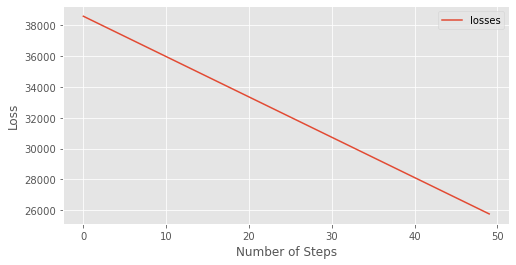

In [12]:
plot_stats_in_graph(metric_dict, y_axis_label='Loss', x_axis_label='Number of Steps')

In [20]:
x = torch.arange(16*128).view(16, 128).float()
y = torch.arange((16))

fcc_net = LinearLayerWithActivation(input_shape=x.shape, num_units=512, bias=True, activation_type=nn.Identity())
optimizer = optim.Adam(fcc_net.parameters(), amsgrad=False, weight_decay=0.0)


for name, params in fcc_net.named_parameters():
    print('Parameters with name', name, 'and shape', params.shape)

metric_dict = {'losses': []}    
    
for i in range(50):

    out = fcc_net.forward(x)
    loss = F.cross_entropy(out, y)
    fcc_net.zero_grad() #removes grads of previous step
    optimizer.zero_grad() #removes grads of previous step
    loss.backward() #compute gradients of current step
    optimizer.step() #update step
    metric_dict['losses'].append(loss.detach().cpu().numpy()) #.detach: Copies the value of the loss 
#                                                               and removes it from the graph, 
#                                                             .cpu() sends to cpu, and 
#                                                              numpy(), converts it to numpy format.

Parameters with name weights and shape torch.Size([512, 128])
Parameters with name bias and shape torch.Size([512])


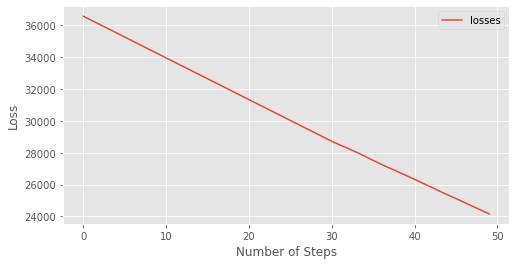

In [14]:
plot_stats_in_graph(metric_dict, y_axis_label='Loss', x_axis_label='Number of Steps')

**TA**: Does that make sense now?

**Student**: Yeah, somewhat. What about more complicated systems? Will I have to implement everything using barebone components like F.linear etc.?

**TA**: You can use existing nn.Modules as components of new nn.Modules therefore, you are able of modularizing your network blocks, and then combining them at the end in one big network with very few lines of code. Pytorch already provides almost every kind of layer out there in their torch.nn package. Look at the [documentation](https://pytorch.org/docs/stable/nn.html) for more information. Now, let's see how we can combine modules to build a larger module. Let's build a multi layer fully connected module.



In [15]:
class MultiLayerFCCNetwork(nn.Module):
    def __init__(self, input_shape, num_hidden_units, num_output_units, num_hidden_layers):
        super(MultiLayerFCCNetwork, self).__init__()
        self.input_shape = input_shape
        self.num_hidden_units = num_hidden_units
        self.num_output_units = num_output_units
        self.num_hidden_layers = num_hidden_layers
        
        x_dummy = torch.zeros(input_shape)
        
        self.layer_dict = nn.ModuleDict() #allows us to initialize modules within a dictionary structure
        out = x_dummy
        for i in range(self.num_hidden_layers):
            self.layer_dict[f'layer_{i}'] = LinearLayerWithActivation(
                input_shape=out.shape, num_units=self.num_hidden_units, bias=True, activation_type=nn.PReLU()
            )
            
            out = self.layer_dict[f'layer_{i}'].forward(out)
        self.layer_dict['output_layer'] = LinearLayerWithActivation(
            input_shape=out.shape, num_units=self.num_hidden_units, bias=True, activation_type=nn.PReLU())
            
    def forward(self, x):
        out = x
        for i in range(self.num_hidden_layers):
            out = self.layer_dict[f'layer_{i}'].forward(out)
        out = self.layer_dict['output_layer'].forward(out)
        return out
        

In [16]:
class MultiLayerFCCNetwork(nn.Module):
    def __init__(self, input_shape, num_hidden_units, num_output_units, num_hidden_layers):
        super(MultiLayerFCCNetwork, self).__init__()
        self.input_shape = input_shape
        self.num_hidden_units = num_hidden_units
        self.num_output_units = num_output_units
        self.num_hidden_layers = num_hidden_layers
        
        x_dummy = torch.zeros(input_shape)
        
        self.layer_dict = nn.ModuleDict() # Allows us to initialize modules within a dictionary structure.
        out = x_dummy
        for i in range(self.num_hidden_layers):
            self.layer_dict['layer_{}'.format(i)] = LinearLayerWithActivation(input_shape=out.shape, 
                                                             num_units=self.num_hidden_units, bias=True,
                                                                       activation_type=nn.PReLU())
            
            out = self.layer_dict['layer_{}'.format(i)].forward(out)
        
        self.layer_dict['output_layer'] = LinearLayerWithActivation(input_shape=out.shape, 
                                                             num_units=self.num_output_units, 
                                                             bias=True, activation_type=nn.Identity())
        out = self.layer_dict['output_layer'].forward(out)
    
    def forward(self, x):
        out = x
        for i in range(self.num_hidden_layers):
            out = self.layer_dict['layer_{}'.format(i)].forward(out)

        out = self.layer_dict['output_layer'].forward(out)
        return out
            
        

In [35]:
fcc_net = MultiLayerFCCNetwork(input_shape=x.shape, num_hidden_units=64, num_output_units=512, 
                               num_hidden_layers=4)
optimizer = optim.Adam(fcc_net.parameters(), amsgrad=False, weight_decay=0.0)


# for name, params in fcc_net.named_parameters():
#     print('Parameters with name', name, 'and shape', params.shape)

metric_dict = {'losses': []}    
    
for i in range(100):

    out = fcc_net.forward(x)
    loss = F.cross_entropy(out, y)
    fcc_net.zero_grad() #removes grads of previous step
    optimizer.zero_grad() #removes grads of previous step
    loss.backward() #compute gradients of current step
    optimizer.step() #update step

    metric_dict['losses'].append(loss.detach().cpu().numpy()) #.detach: Copies the value of the loss 
#                                                               and removes it from the graph, 
#                                                             .cpu() sends to cpu, and 
#                                                              numpy(), converts it to numpy format.
    for name, params in fcc_net.named_parameters():
        print('Parameters with name', name, 'and shape', params.shape)
        print("Gradients")
#         print(params.grad)
        print(torch.abs(params.grad).mean().detach().cpu().numpy())
        print(torch.abs(params.grad.mean()).detach().cpu().numpy())

Parameters with name layer_dict.layer_0.weights and shape torch.Size([64, 128])
Gradients
154782.78
77477.03
Parameters with name layer_dict.layer_0.bias and shape torch.Size([64])
Gradients
154.58734
78.64388
Parameters with name layer_dict.layer_0.activation_type.weight and shape torch.Size([1])
Gradients
34649984.0
34649984.0
Parameters with name layer_dict.layer_1.weights and shape torch.Size([64, 64])
Gradients
176379.53
51226.35
Parameters with name layer_dict.layer_1.bias and shape torch.Size([64])
Gradients
27.879078
13.011753
Parameters with name layer_dict.layer_1.activation_type.weight and shape torch.Size([1])
Gradients
14074371.0
14074371.0
Parameters with name layer_dict.layer_2.weights and shape torch.Size([64, 64])
Gradients
151522.39
45228.754
Parameters with name layer_dict.layer_2.bias and shape torch.Size([64])
Gradients
3.8552334
1.9317064
Parameters with name layer_dict.layer_2.activation_type.weight and shape torch.Size([1])
Gradients
20444592.0
20444592.0
Parame

7332126.0
7332126.0
Parameters with name layer_dict.layer_2.weights and shape torch.Size([64, 64])
Gradients
111410.89
9682.355
Parameters with name layer_dict.layer_2.bias and shape torch.Size([64])
Gradients
2.8942413
0.64548934
Parameters with name layer_dict.layer_2.activation_type.weight and shape torch.Size([1])
Gradients
20985560.0
20985560.0
Parameters with name layer_dict.layer_3.weights and shape torch.Size([64, 64])
Gradients
104174.19
20632.166
Parameters with name layer_dict.layer_3.bias and shape torch.Size([64])
Gradients
0.46291038
0.18206212
Parameters with name layer_dict.layer_3.activation_type.weight and shape torch.Size([1])
Gradients
3303778.5
3303778.5
Parameters with name layer_dict.output_layer.weights and shape torch.Size([512, 64])
Gradients
3357.5854
9.536743e-07
Parameters with name layer_dict.output_layer.bias and shape torch.Size([512])
Gradients
0.00390625
0.0
Parameters with name layer_dict.layer_0.weights and shape torch.Size([64, 128])
Gradients
10638

63668.797
14511.727
Parameters with name layer_dict.layer_0.bias and shape torch.Size([64])
Gradients
62.160378
14.081459
Parameters with name layer_dict.layer_0.activation_type.weight and shape torch.Size([1])
Gradients
5025143.0
5025143.0
Parameters with name layer_dict.layer_1.weights and shape torch.Size([64, 64])
Gradients
57533.92
7641.2554
Parameters with name layer_dict.layer_1.bias and shape torch.Size([64])
Gradients
9.3906145
3.4058082
Parameters with name layer_dict.layer_1.activation_type.weight and shape torch.Size([1])
Gradients
15980610.0
15980610.0
Parameters with name layer_dict.layer_2.weights and shape torch.Size([64, 64])
Gradients
66558.09
1745.8894
Parameters with name layer_dict.layer_2.bias and shape torch.Size([64])
Gradients
2.0426588
0.17659745
Parameters with name layer_dict.layer_2.activation_type.weight and shape torch.Size([1])
Gradients
7369314.0
7369314.0
Parameters with name layer_dict.layer_3.weights and shape torch.Size([64, 64])
Gradients
62132.812

2205.4763
1.3187528e-05
Parameters with name layer_dict.output_layer.bias and shape torch.Size([512])
Gradients
0.00390625
0.0
Parameters with name layer_dict.layer_0.weights and shape torch.Size([64, 128])
Gradients
64278.152
14178.683
Parameters with name layer_dict.layer_0.bias and shape torch.Size([64])
Gradients
61.64439
19.635496
Parameters with name layer_dict.layer_0.activation_type.weight and shape torch.Size([1])
Gradients
11719880.0
11719880.0
Parameters with name layer_dict.layer_1.weights and shape torch.Size([64, 64])
Gradients
78987.164
10109.742
Parameters with name layer_dict.layer_1.bias and shape torch.Size([64])
Gradients
11.377344
3.5867665
Parameters with name layer_dict.layer_1.activation_type.weight and shape torch.Size([1])
Gradients
8991038.0
8991038.0
Parameters with name layer_dict.layer_2.weights and shape torch.Size([64, 64])
Gradients
65767.12
11364.706
Parameters with name layer_dict.layer_2.bias and shape torch.Size([64])
Gradients
1.9492793
0.88666373


60670.72
636.8185
Parameters with name layer_dict.layer_2.bias and shape torch.Size([64])
Gradients
1.9051294
0.2442913
Parameters with name layer_dict.layer_2.activation_type.weight and shape torch.Size([1])
Gradients
6791080.0
6791080.0
Parameters with name layer_dict.layer_3.weights and shape torch.Size([64, 64])
Gradients
56271.156
4549.4844
Parameters with name layer_dict.layer_3.bias and shape torch.Size([64])
Gradients
0.30631638
0.09031753
Parameters with name layer_dict.layer_3.activation_type.weight and shape torch.Size([1])
Gradients
4180611.8
4180611.8
Parameters with name layer_dict.output_layer.weights and shape torch.Size([512, 64])
Gradients
2047.9272
9.953976e-06
Parameters with name layer_dict.output_layer.bias and shape torch.Size([512])
Gradients
0.00390625
0.0
Parameters with name layer_dict.layer_0.weights and shape torch.Size([64, 128])
Gradients
49878.97
13217.707
Parameters with name layer_dict.layer_0.bias and shape torch.Size([64])
Gradients
55.899197
18.0176

837420.56
837420.56
Parameters with name layer_dict.layer_3.weights and shape torch.Size([64, 64])
Gradients
35132.047
568.40405
Parameters with name layer_dict.layer_3.bias and shape torch.Size([64])
Gradients
0.23034771
0.023780508
Parameters with name layer_dict.layer_3.activation_type.weight and shape torch.Size([1])
Gradients
4629533.0
4629533.0
Parameters with name layer_dict.output_layer.weights and shape torch.Size([512, 64])
Gradients
1514.6484
8.650124e-06
Parameters with name layer_dict.output_layer.bias and shape torch.Size([512])
Gradients
0.0034179688
0.0
Parameters with name layer_dict.layer_0.weights and shape torch.Size([64, 128])
Gradients
60914.863
6053.726
Parameters with name layer_dict.layer_0.bias and shape torch.Size([64])
Gradients
45.77583
8.714688
Parameters with name layer_dict.layer_0.activation_type.weight and shape torch.Size([1])
Gradients
13830774.0
13830774.0
Parameters with name layer_dict.layer_1.weights and shape torch.Size([64, 64])
Gradients
72194

8118302.0
Parameters with name layer_dict.output_layer.weights and shape torch.Size([512, 64])
Gradients
1471.0701
5.841255e-06
Parameters with name layer_dict.output_layer.bias and shape torch.Size([512])
Gradients
0.0031738281
0.0


In [18]:
print(x.shape)
fcc_net = MultiLayerFCCNetwork(input_shape=x.shape, num_hidden_units=64, num_output_units=512, num_hidden_layers=4)
optimizer = optim.Adam(fcc_net.parameters(), amsgrad=False, weight_decay=0.0)

for name, params in fcc_net.named_parameters():
    print('Parameters with name', name, 'and shape', params.shape)
    
metric_dict = {'losses': []}    

for i in range(100):
    out = fcc_net.forward(x)
    loss = F.cross_entropy(out, y)
    fcc_net.zero_grad()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    metric_dict['losses'].append(loss.detach().cpu().numpy())

torch.Size([16, 128])
Parameters with name layer_dict.layer_0.weights and shape torch.Size([64, 128])
Parameters with name layer_dict.layer_0.bias and shape torch.Size([64])
Parameters with name layer_dict.layer_0.activation_type.weight and shape torch.Size([1])
Parameters with name layer_dict.layer_1.weights and shape torch.Size([64, 64])
Parameters with name layer_dict.layer_1.bias and shape torch.Size([64])
Parameters with name layer_dict.layer_1.activation_type.weight and shape torch.Size([1])
Parameters with name layer_dict.layer_2.weights and shape torch.Size([64, 64])
Parameters with name layer_dict.layer_2.bias and shape torch.Size([64])
Parameters with name layer_dict.layer_2.activation_type.weight and shape torch.Size([1])
Parameters with name layer_dict.layer_3.weights and shape torch.Size([64, 64])
Parameters with name layer_dict.layer_3.bias and shape torch.Size([64])
Parameters with name layer_dict.layer_3.activation_type.weight and shape torch.Size([1])
Parameters with n

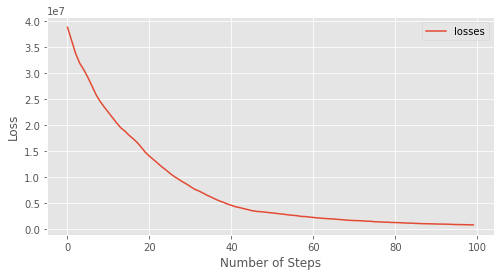

In [19]:
plot_stats_in_graph(metric_dict, y_axis_label='Loss', x_axis_label='Number of Steps')

**TA**: There we go, the network is doing much better during training with a multi-layer neural network. :)

**Student**: Hmm.. I am weirdly excited even though I have not digested this completely yet. Where do I go to learn more? 

**TA**: Firstly, I think you should go and have a look at the MLP Pytorch Framework, so you can learn how Pytorch can be used with more complicated architectures, as well as to learn some good coding practices for research and industry alike. When you are working on your coursework, make sure to have the [pytorch official documentation page](https://pytorch.org/docs/stable/nn.html) open in your browser, as it is extremely well written most of the times. Then, when you have some spare time, perhaps in preparation for next term, I would recommend going through some of the Pytorch tutorials at the [pytorch tutorials page](https://pytorch.org/tutorials/). Finally, the best way to learn, in my opinion, is by engaging with Pytorch through a project that interests you.